In [1]:
from collections import defaultdict
import pandas as pd
import gzip
from tqdm import *
import numpy as np 
import random
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import math
import matplotlib.pyplot as plt
from model import BPR_MF, BPR_MF_DNS, BPR_MF_ANS, APR

In [2]:
path = "./data/"
file_list = ['kaggle.txt', 'pinterest-20.train.rating', 'yelp.rating']
ml = pd.read_csv(path+file_list[0],sep='\t',header=None,names=['userID','bookID','rating','stamp'])
ml = ml.drop(['rating','stamp'], axis=1)
ml['label'] = [1]*len(ml)
print(ml.shape)
ml.head()

(200000, 3)


,userID,bookID,label
0,3645,0,1
1,4514,6601,1
2,1947,440,1
3,7382,5022,1
4,3773,4466,1


In [3]:
ml_group = ml.groupby('userID',sort=False).bookID.unique().agg(len)

In [4]:
ml_meanlength = ml_group.values.mean()
ml_overaverage = sum((ml_group.values > ml_meanlength))/len(ml_group.values)
ml_lessaverage = sum((ml_group.values <= ml_meanlength))/len(ml_group.values)
print('average number of reading books per user: ',ml_meanlength)
print(f'percentage of users reading more than average: {round(ml_overaverage*100,2)}%')
print(f'percentage of users reading less than average: {round(ml_lessaverage*100,2)}%')

average number of reading books per user:  17.610284406093157
percentage of users reading more than average: 38.52%
percentage of users reading less than average: 61.48%


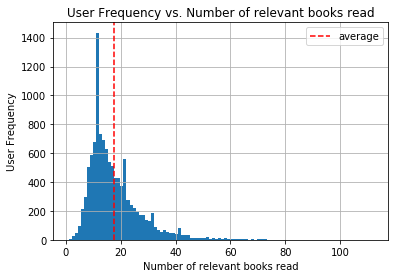

In [5]:
freq, edges, pathches = plt.hist(ml_group, bins=100)
plt.axvline(x=ml_meanlength, linestyle='--',color='r',label='average')
plt.legend()
plt.title('User Frequency vs. Number of relevant books read')
plt.xlabel('Number of relevant books read')
plt.ylabel('User Frequency')
plt.grid()

In [6]:
%load_ext line_profiler

In [7]:
def get_embedding(data):
    users, books = data['userID'].values, data['bookID'].values
    user_books = defaultdict(set)
    usernotread = defaultdict(list)
    for i in range(len(users)):
        user_books[users[i]].add(books[i])
    all_users, all_books = list(set(users)), set(books)
    # embedding
    user2index, book2index = defaultdict(int), defaultdict(int)
    for i in range(len(all_users)):
        u = all_users[i]
        user2index[u] = i
        usernotread[u] = list(all_books-user_books[u])
    all_books = list(all_books)
    for j in range(len(all_books)):
        book2index[all_books[j]] = j
        
    return all_users, all_books, user_books, user2index, book2index, usernotread

In [8]:
def generate_negative(train_data, data, sample_num):
    negative_train = []
    users_train, books_train, labels_train = train_data['userID'].values, train_data['bookID'].values, train_data['label'].values
    all_users_train, all_books_train, user_books_train, _, _, _ = get_embedding(train_data)
    all_users, all_books, user_books, _, _, usernotread = get_embedding(data)
    
    for i in tqdm_notebook(range(len(train_data))):
        u, b, label = users_train[i], books_train[i], labels_train[i]
        _b = random.sample(usernotread[u],sample_num) # the negative samples are selected from the whole dataset's negative samples
        for b0 in _b:
            negative_train.append([u, b0, 0])
            usernotread[u].remove(b0)    

    negative_data_train = pd.DataFrame(negative_train) 
    negative_data_train.columns = ['userID', 'bookID', 'label']
    train_data_mix = train_data.append(negative_data_train, ignore_index=True)
    return train_data_mix

In [9]:
def oneuserpos(valid_data):
    data = []
    users, books = valid_data['userID'].values, valid_data['bookID'].values
    user_books = defaultdict(set)
    for i in range(len(users)):
        user_books[users[i]].add(books[i])
        
    for u in user_books.keys():
        b = random.choice(list(user_books[u]))
        data.append([u,b,1])
        
    data = np.array(data)
    dataset = pd.DataFrame({'userID': data[:, 0], 'bookID': data[:, 1], 'label': data[:, 2]})
    return dataset

In [10]:
train_ml, valid_ml = train_test_split(ml, test_size=1/20)
valid_ml = oneuserpos(valid_ml)
valid_ml_mix = generate_negative(valid_ml, ml, 99)

Xtrain_ml = np.concatenate((train_ml['userID'].values.reshape(-1,1)
                         ,train_ml['bookID'].values.reshape(-1,1) 
                        ),axis=1)
ytrain_ml = train_ml['label'].values
Xvalid_ml_mix = np.concatenate((valid_ml_mix['userID'].values.reshape(-1,1), 
                         valid_ml_mix['bookID'].values.reshape(-1,1), 
                        ),axis=1)
yvalid_ml_mix = valid_ml_mix['label'].values

HBox(children=(IntProgress(value=0, max=6266), HTML(value='')))

In [11]:
print(valid_ml.shape)
print(yvalid_ml_mix.shape)

(6266, 3)
(626600,)


## Models BPR training

In [12]:
%%time
p_lambda = 0.1
lr = 0.1
max_epoch = 100
dimension = 50
eva_k = 10
batch_size = 64
record_epoch = 50

model_bpr = BPR_MF(p_lambda, lr, max_epoch, dimension, eva_k, batch_size)
%lprun -f model_bpr.fit model_bpr.fit(train_ml, Xvalid_ml_mix, yvalid_ml_mix, record_epoch)

HBox(children=(IntProgress(value=0), HTML(value='')))

epoch: 1, HR: 0.08442387488030642, NDCG: 0.035504344431690676, AUC: 0.5036609310468236
epoch: 2, HR: 0.08873284391956592, NDCG: 0.038850673094727124, AUC: 0.5085228280249017
epoch: 3, HR: 0.12879029684008936, NDCG: 0.06061128572189616, AUC: 0.540300870176388
epoch: 4, HR: 0.24273858921161826, NDCG: 0.12671716349457646, AUC: 0.6255420467038758
epoch: 5, HR: 0.34806894350462814, NDCG: 0.18467737213699378, AUC: 0.7073431409531048
epoch: 6, HR: 0.3777529524417491, NDCG: 0.20020268671098765, AUC: 0.7378750801987414
epoch: 7, HR: 0.37392275774018513, NDCG: 0.19793956594899118, AUC: 0.7351507413748168
epoch: 8, HR: 0.3662623683370571, NDCG: 0.1956018109087478, AUC: 0.7348251103437873
epoch: 9, HR: 0.36977338014682415, NDCG: 0.19662035584054094, AUC: 0.7376445592213295
epoch: 10, HR: 0.38589211618257263, NDCG: 0.2010387397711604, AUC: 0.7474602391614943
epoch: 11, HR: 0.3951484200446856, NDCG: 0.2080087545187121, AUC: 0.7592087488353115
epoch: 12, HR: 0.4052026811362911, NDCG: 0.21361785993467

epoch: 97, HR: 0.475422917331631, NDCG: 0.2578142039487237, AUC: 0.8171871927058774
epoch: 98, HR: 0.48068943504628153, NDCG: 0.25956381160803943, AUC: 0.8168486653963976
epoch: 99, HR: 0.4727098627513565, NDCG: 0.2533183731853829, AUC: 0.8164472687294387
epoch: 100, HR: 0.46648579636131504, NDCG: 0.2547694311123035, AUC: 0.8161087414199554

CPU times: user 6min 50s, sys: 1.58 s, total: 6min 51s
Wall time: 6min 54s


## Models DNS training

In [16]:
%%time
beta = 0.5
ada = 10
p_lambda = 0.1
lr = 0.1
max_epoch = 100
dimension = 50
eva_k = 10
batch_size = 64

model_dns = BPR_MF_DNS(beta, ada, p_lambda, lr, max_epoch, dimension, eva_k, batch_size)
%lprun -f model_dns.fit model_dns.fit(train_ml, Xvalid_ml_mix, yvalid_ml_mix)

NameError: name 'BPR_DNS_Linear' is not defined

In [66]:
%%time
ada = 10
p_lambda = 0.1
lr = 0.1
max_epoch = 100
dimension = 50
eva_k = 10
batch_size = 64

model_ans = ANS(ada, p_lambda, lr, max_epoch, dimension, eva_k, batch_size)
%lprun -f model_ans.fit model_ans.fit(train_ml, Xvalid_ml_mix, yvalid_ml_mix)

C:\Users\Yufei\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app


epoch: 1, HR: 0.5219721329046088, NDCG: 0.2988104906189313, AUC: 0.8478857889361731
epoch: 2, HR: 0.5612718828152912, NDCG: 0.3304625262492752, AUC: 0.8608395494783619
epoch: 3, HR: 0.5912826009289032, NDCG: 0.3466344202935831, AUC: 0.8699445328598728
epoch: 4, HR: 0.5973561986423723, NDCG: 0.35343753367055947, AUC: 0.8739087913793272
epoch: 5, HR: 0.609146123615577, NDCG: 0.3612846016722995, AUC: 0.8750419522123827
epoch: 6, HR: 0.6062879599857092, NDCG: 0.36450167536415495, AUC: 0.8774562343694302
epoch: 7, HR: 0.6187924258663808, NDCG: 0.36210471444676506, AUC: 0.8773335354257241
epoch: 8, HR: 0.613969274740979, NDCG: 0.36423409077266244, AUC: 0.8788023139577407
epoch: 9, HR: 0.6186137906395142, NDCG: 0.37066420306766384, AUC: 0.8788600546371313
epoch: 10, HR: 0.6150410861021793, NDCG: 0.3615158582196752, AUC: 0.8774814959166647
epoch: 11, HR: 0.6046802429439085, NDCG: 0.3599716050730673, AUC: 0.878333170937686
epoch: 12, HR: 0.6161128974633798, NDCG: 0.37039850443286065, AUC: 0.879

In [69]:
%%time
p_lambda = 0.001
p_adv = 0.2
eps = 0.5
lr = 0.1
s_epoch = record_epoch
e_epoch = max_epoch
dimension = 50
eva_k = 10
batch_size = 64
w_ml_bpr, h_ml_bpr = model_bpr.record_w.copy(), model_bpr.record_h.copy()
model_apr = APR(p_lambda, p_adv, eps, lr, s_epoch, e_epoch, dimension, eva_k, batch_size)
model_apr.fit(w_ml_bpr, h_ml_bpr, train_ml, Xvalid_ml_mix, yvalid_ml_mix)

epoch: 50, HR: 0.6014648088603073, NDCG: 0.3518493319109833, AUC: 0.8769708517832994


epoch: 51, HR: 0.6396927474097892, NDCG: 0.3818194553072318, AUC: 0.8906499796103348
epoch: 52, HR: 0.6579135405501965, NDCG: 0.3978980687581505, AUC: 0.8951699921689323
epoch: 53, HR: 0.6516613076098606, NDCG: 0.3964711733791633, AUC: 0.8957239418118432
epoch: 54, HR: 0.6654162200785995, NDCG: 0.3972144729364356, AUC: 0.897654645778989
epoch: 55, HR: 0.6677384780278671, NDCG: 0.3965622256339792, AUC: 0.8984684284791615
epoch: 56, HR: 0.6680957484816006, NDCG: 0.4066533322100433, AUC: 0.8992172529150185
epoch: 57, HR: 0.6639871382636656, NDCG: 0.40020926758181447, AUC: 0.8983421207429915
epoch: 58, HR: 0.68345837799214, NDCG: 0.4131465492888384, AUC: 0.9015304888831327
epoch: 59, HR: 0.6818506609503394, NDCG: 0.4146510044971119, AUC: 0.9029054388111333
epoch: 60, HR: 0.6847088245802072, NDCG: 0.4181580635540877, AUC: 0.9041883645313618
epoch: 61, HR: 0.6798856734548053, NDCG: 0.4128077637712789, AUC: 0.9047062262496511
epoch: 62, HR: 0.6938192211504108, NDCG: 0.421817869389814, AUC: 0.

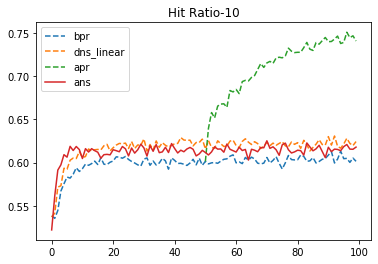

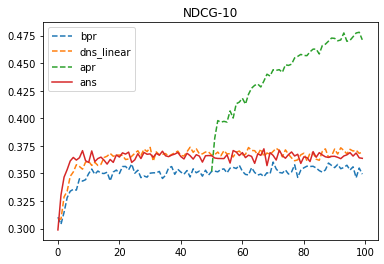

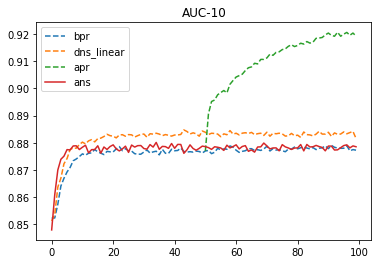

In [70]:
import matplotlib.pyplot as plt
#plt.figure(figsize=(10,6))
plt.plot(model_bpr.hr,label='bpr',linestyle="--")
plt.plot(model_dns.hr,label='dns_linear',linestyle="--")
plt.plot(range(s_epoch,e_epoch),model_apr.hr[:-1],label='apr',linestyle="--")
plt.plot(model_ans.hr,label='ans')
plt.legend()
plt.title('Hit Ratio-10')
plt.show()
#plt.figure(figsize=(10,6))
plt.plot(model_bpr.ndcg,label='bpr',linestyle="--")
plt.plot(model_dns.ndcg,label='dns_linear',linestyle="--")
plt.plot(range(s_epoch,e_epoch),model_apr.ndcg[:-1],label='apr',linestyle="--")
plt.plot(model_ans.ndcg,label='ans')
plt.legend()
plt.title('NDCG-10')
plt.show()
#plt.figure(figsize=(10,6))
plt.plot(model_bpr.auc,label='bpr',linestyle="--")
plt.plot(model_dns.auc,label='dns_linear',linestyle="--")
plt.plot(range(s_epoch,e_epoch),model_apr.auc[:-1],label='apr',linestyle="--")
plt.plot(model_ans.auc,label='ans')
plt.legend()
plt.title('AUC-10')
plt.show()